# Preface
To enable collaboration, a singularity and venv environment is provided. The idea is that anyone comeing to this project can re-run and edit it. 

Ideally, all relevant data will be stored in an internal database, or, alternatively, in a file location than anyone in the organisation can access. 

On licensing: I'm aware that in a commercial setting licenses do matter. However, in this taks I've excluded that research. 


# Environment Setup
To enable reproducible and collaborative research a common environment is essential. The environment for this project consists of a singularity container in conjunction with a R-renv and python-venv environment. 

Create the following folder structure on your linux system:

```
-demo
    ├── scripts
    ├── envs
    ├── workdir
    └── data
```

The singularity container used in this work is available on dockerhub: [Link](https://hub.docker.com/repository/docker/boeings/r450.python310.ubuntu.22.04)

Navigate to the `envs` directory. 

The commands below contain system specific components which you will have to adapt to your system. 

```{bash}
## Go to envs folder ##
cd envs

## Activate the singularity module ##
ml Singularity/3.6.4

## Pull singularity container from dockerhub
singularity pull docker://boeings/r450.python310.ubuntu.22.04

## Navigating to the workdir ##
cd ../workdir

## Starting the singularity container ##
You need to adjust the file paths for the --bind flag as appropriate on your system.

General syntax:
singularity shell --cleanenv --bind </folder/on/host/system/data>:/data ../envs/r450.python310.ubuntu.22.04_latest.sif

Specific example:
singularity shell --cleanenv --bind /nemo:/nemo,/camp:/camp,/flask:/flask ../envs/r450.python310.ubuntu.22.04_latest.sif

## Or create venv environment in the current folder (change path if you'd like to store the venv environment files elsewhere) ##
This is only required once at the beginning of the project, so will be commented out for now. 
# python3.10 -m venv ../envs/demo_venv_310

## Activate venv environment ##
source ../envs/demo_venv_310/bin/activate

## Save venv.lock documentation file ##
## Save venv package environment     ##
pip freeze > ../envs/venv.lock
## Reload venv environment from venv.lock file ##
pip install -r ../envs/venv.lock

## Start python ##
cd ../workdir
python



# Parameter and Constants

In [29]:
depmap_fn = '../../../../data/depmap/depmap_data_object.pkl'

gtex_fn = '../../../../data/gtex.subset.pkl'


# Data Preparation

## DepMap Data Preparation

In [2]:
###################################################################
## DepMap data preparation                                       ##
## Data preparation chunk. This needs to be run only once.       ##
## Subsequently the data will be loaded in a summary data object ##
###################################################################


import pandas as pd
import numpy as np
import requests
from io import StringIO
import anndata
import mudata
import wrangle_depmap_data

def get_depmap_files(files_url = "https://depmap.org/portal/api/download/files"):
        """Fetch available DepMap files from the portal API"""
        response = requests.get(files_url, timeout=30)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text))


def load_depmap_file(filename, df_files_filt):
    """Load depmap file, but stop if filename not found."""
    file_sel_df = df_files_filt[df_files_filt['filename'].str.contains(filename)]
    if file_sel_df.empty:
        raise ValueError(f"File matching '{filename}' not found in df_files_filt.")
    file_url = file_sel_df["url"].values[0]
    response = requests.get(file_url, timeout=30)
    response.raise_for_status()
    if filename.endswith('.csv'):
        df_file = pd.read_csv(StringIO(response.text), low_memory=False)
    elif filename.endswith('.txt'):
        df_file = pd.read_csv(StringIO(response.text), sep="\t", low_memory=False)
    else:
        raise ValueError("Unsupported file type")
    return df_file  

## Get recent file list
df_files = get_depmap_files(files_url = "https://depmap.org/portal/api/download/files")

## For duplicated files, keep only the most recent version
# Sort by release_date descending, then drop duplicates keeping the first (latest)
df_files_filt = df_files.sort_values('release_date', ascending=False).drop_duplicates(subset='filename', keep='first')

# tpm OmicsExpressionAllGenesTPMLogp1StrandedProfile.csv
#filename = "OmicsExpressionAllGenesTPMLogp1StrandedProfile.csv"
# filename = "OmicsExpressionTPMLogp1HumanAllGenesStranded.csv"


## Get metadata
# metadata cell lines, screens, genes
filename = "Model.csv"
df_metadata = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
# Set modelID as index in df_metadata for easy alignment
df_metadata = df_metadata.set_index('ModelID')

filename = "OmicsProfiles.csv"
df_profiles = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_profiles = df_profiles.set_index('ModelID')

## File selections were made based on paths in https://depmap.org/portal/data_page/?tab=customDownloads

###############################################################################
## Create TPM anndata object                                                 ##
import anndata
import pandas as pd

filename = "OmicsExpressionTPMLogp1HumanProteinCodingGenes.csv"
df_tpm = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_tpm = df_tpm[df_tpm["IsDefaultEntryForModel"] == "Yes"]
df_tpm = df_tpm.set_index('ModelID')
cols_to_delete = df_tpm.columns.to_list()[0:5]
cols_to_delete
df_tpm_adata = df_tpm.drop(columns=cols_to_delete)
df_tpm_adata.columns = [col.split(" (")[0] for col in df_tpm_adata.columns]
# Check if columns are unique
df_tpm_adata.columns.is_unique
df_tpm_adata.index.is_unique

# If df_tpm_adata has features as row index and gene names as columns
  # Transpose to have samples/cells as rows and features/genes as columns
adata_tpm = anndata.AnnData(
    X=df_tpm_adata.values,
    obs=pd.DataFrame(index=df_tpm_adata.index),   # samples/cells
    var=pd.DataFrame(index=df_tpm_adata.columns)      # features/genes
)

adata_tpm.obs = adata_tpm.obs.join(df_metadata)


## Done with TPM anndata object                                              ##
###############################################################################

###############################################################################
## Create count data object for differential gene expression                 ##
filename = "OmicsExpressionRawReadCountHumanProteinCodingGenes.csv"
df_counts = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_counts = df_counts[df_counts["IsDefaultEntryForModel"] == "Yes"]
df_counts = df_counts.set_index('ModelID')
cols_to_delete = df_counts.columns.to_list()[0:5]
cols_to_delete
df_counts_adata = df_counts.drop(columns=cols_to_delete)
df_counts_adata.columns = [col.split(" (")[0] for col in df_counts_adata.columns]
# Check if rows and columns are unique
df_counts_adata.columns.is_unique
df_counts_adata.index.is_unique

## Done counts                                                               ##
###############################################################################

###############################################################################
## Create CRISPR anndata object                                              ##
import anndata
import pandas as pd

filename = "CRISPRGeneEffect.csv"
df_crispr = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_crispr = df_crispr.rename(columns={"Unnamed: 0": "ModelID"})
df_crispr = df_crispr.set_index('ModelID')
df_crispr.columns = [col.split(" (")[0] for col in df_crispr.columns]
# Check if columns are unique
df_crispr.columns.is_unique
df_crispr.index.is_unique


# If df_tpm_adata has features as row index and gene names as columns
  # Transpose to have samples/cells as rows and features/genes as columns
adata_crispr = anndata.AnnData(
    X=df_crispr.values,
    obs=pd.DataFrame(index=df_crispr.index),   # samples/cells
    var=pd.DataFrame(index=df_crispr.columns)      # features/genes
)

adata_crispr.obs = adata_crispr.obs.join(df_metadata)


## Done with TPM anndata object                                              ##
###############################################################################



###############################################################################
## drug response                                                             ##

# drug response metadata
# Create a lookup table between sampleIDs and compound names
filename = "PortalCompounds.csv"
df_compounds = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_rename = df_compounds[['CompoundName', 'SampleIDs']]
df_compounds = df_compounds.set_index('SampleIDs')


filename = "../../../../data/depmap/Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv"
df_drugs = pd.read_csv(filename )
df_drugs = df_drugs.rename(columns={"Unnamed: 0": "SampleIDs"})
df_drugs = df_drugs.set_index('SampleIDs')

df_drugs = df_drugs.T

df_drugs.columns.is_unique
df_drugs.index.is_unique



adata_drugs = anndata.AnnData(
    X=df_drugs.values,
    obs=pd.DataFrame(index=df_drugs.index),   # samples/cells
    var=pd.DataFrame(index=df_drugs.columns)      # features/genes/drugs
)

## cell line level metadata
adata_drugs.obs = adata_drugs.obs.join(df_metadata)

## Add drug metadata (added to columns)
adata_drugs.var = adata_drugs.var.join(df_compounds, how='left')



## Done                                                                      ##
###############################################################################

###############################################################################
## Copy number variation (CNV)                                               ##

#CN
#filename="OmicsCNGene.csv"
filename="PortalOmicsCNGeneLog2.csv"
df_cn = load_depmap_file(filename = filename, df_files_filt = df_files_filt)
df_cn = df_cn.rename(columns={"Unnamed: 0": "ModelID"})
df_cn = df_cn.set_index('ModelID')
df_cn.columns = [col.split(" (")[0] for col in df_cn.columns]

## keep only column present in df_tpm_adata
df_cn = df_cn[df_cn.columns.intersection(df_tpm_adata.columns)]
df_cn.columns.is_unique
df_cn.index.is_unique

adata_cn = anndata.AnnData(
    X=df_cn.values,
    obs=pd.DataFrame(index=df_cn.index),   # samples/cells
    var=pd.DataFrame(index=df_cn.columns)      # features/genes
)

adata_cn.obs = adata_cn.obs.join(df_metadata)

## Done                                                                      ##
###############################################################################

###############################################################################
## Get common essential genes                                                ##
filename = "../../../../data/AchillesCommonEssentialControls.csv"
df_AchillesCommonEssentialControls = pd.read_csv(filename)

###############################################################################
## protein                                                                   ##
## to be added later - required Uniprot > gene name conversion
filename = "harmonized_RPPA_CCLE.csv"
df_protein = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

## Done                                                                      ##
###############################################################################

###############################################################################
## Other data modalities could be added as needed                            ##

# rnai - can be added later. 
filename = "D2_combined_gene_dep_scores.csv"
df_rnai = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

# filename = "Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv"
# df_drugs = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

# methylation
filename = "CCLE_RRBS_TSS_1kb_20180614.txt"
df_methylation = load_depmap_file(filename = filename, df_files_filt = df_files_filt)

## Done optional additions                                                   ##
###############################################################################

##################################################################################
## Initialize depmap data object with loaded datasets                           ##


from wrangle_depmap_data import depmapData

depmap_data = depmapData(
    df_tpm=df_tpm_adata,
    df_counts=df_counts_adata,
    df_cn=df_cn,
    df_drugs=df_drugs,
    df_crispr=df_crispr,
    df_metadata=df_metadata,
    df_profiles=df_profiles
)

## Inspect
depmap_data.data_shapes()

## Subset to cell lines present in all data modalities ##
common_samples = depmap_data.list_common_cell_lines()
common_features = depmap_data.list_common_features()

## Optional: Subset to common cell lines ##
# depmap_data_common = depmap_data.subset_to_common_cell_lines()
# depmap_data_common.data_shapes()

## Optional: Select features of interest ##
#depmap_data_consensus = depmap_data_common.subset_to_common_features()
#depmap_data_consensus.data_shapes()

## Optional: Further subset cells ##
# depmap_data_min = depmap_data_consensus.subset_to_random_cells(n_cells = 100)
#depmap_data_min.data_shapes()

## Check if features of interest are present in all or some modalities
# feature_check = depmap_data_consensus.feature_presence(['EZH1', 'EZH2', 'STK19', 'C7orf26'])


## Check if features of interest are present in the various data modalities
#for key, value in feature_check.items():
#    print(f"Feature: {key}, Present in: {value}")


## save to file ##
outputfile = depmap_fn
depmap_data.save_data(filepath=outputfile)
print(f"Depmap data object saved at {outputfile}")

###################################
## Loading depmap dataset object ##
###################################

import os

if os.path.exists(outputfile):
    print(f"Loading existing depmap_data from {outputfile}")
    depmap_data = depmapData.load_data(outputfile)
else:
    print(f"File {outputfile} not found, using newly created depmap_data object")
    # depmap_data already exists from the creation code above

#####################################
## Done loading depmap data object ##
#####################################


df_metadata: (2132, 48)
df_profiles: (4775, 17)
df_tpm: (1699, 19215)
df_counts: (1699, 19215)
df_cn: (1095, 18399)
df_drugs: (919, 6790)
df_crispr: (1186, 18435)
Number of common cell lines: 544
Number of common features: 18118
Depmap data object saved at ../../../../data/depmap/depmap_data_object.pkl
Loading existing depmap_data from ../../../../data/depmap/depmap_data_object.pkl


## GTEx data preparation

In [3]:
###################################################################
## GTEx data preparation                                         ##
## Data preparation chunk. This needs to be run only once.       ##
## Subsequently the data will be loaded in a summary data object ##
###################################################################

import pandas as pd
import numpy as np

## Step 1: Load metadata
## Setep 2: Subset metadata 
## step 3 : preare count data
## step 4: prepare tpm data

FNmeta = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

df_meta = pd.read_csv(
    FNmeta,
    sep="\t"
)
df_meta_sel = df_meta[['SAMPID', 'SMTS', 'SMAFRZE']].copy()

## Add Subjid
df_meta_sel['SUBJID'] = df_meta_sel['SAMPID'].str.split('-').str[:2].str.join('-')


## Load phenotype data
FNmeta = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_Annotations_SubjectPhenotypesDS.txt"
df_pheno = pd.read_csv(
    FNmeta,
    sep="\t"
)

df_joined = pd.merge(df_pheno, df_meta_sel, on="SUBJID", how="inner")
df_joined['SEX'] = df_joined['SEX'].replace({1: 'M', 2: 'F'})
df_joined['SMTS'] = df_joined['SMTS'].str.replace(' ', '')

## Filter for specific tissue or subset ##
## Filter on Method
## List all methods
available_methods = sorted(df_joined['SMAFRZE'].dropna().unique().tolist())
print(f"Available methods: {available_methods}")

## Filter on RNASeq
df_gtex_meta = df_joined[df_joined['SMAFRZE'] == 'RNASEQ']

df_gtex_meta.set_index('SAMPID', inplace=True)

## List available tissue
available_tissues = sorted(df_gtex_meta['SMTS'].dropna().unique())
print(f"Available tissues: {available_tissues}")

## Optional filtering on tissue ##

## Optional filtering on age range ##



## Optional: plot gender/age/organ distribution ##

######################################
## Load gtex  count data and subset ##
######################################

## Load count data
##    Selections: column names / cell ids
##    Min-count per row filtering (default row mean >= 1)

FNgtex = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_reads.gct.gz"
df_count_gtex = pd.read_csv(
    FNgtex,
    sep="\t",
    skiprows=2, 
    low_memory=False
)
df_count_gtex.shape
## To speed up DGE comparisons, filter for lowly expressed genes. 
## Here we will require at least one count per sample on average
df_count_gtex.rename(columns={'Description': 'gene_id'}, inplace=True)
df_count_gtex.set_index('gene_id', inplace=True)

numeric_cols = df_count_gtex.select_dtypes(include='number').columns

df_count_gtex = df_count_gtex[numeric_cols]

## Check df_count_gtext
# Get all sample IDs present in the metadata
sampid_set = set(df_gtex_meta.index)
# Get the intersection of sample IDs present in both metadata and count data
sample_ids = [col for col in df_count_gtex.columns if col in sampid_set]
df_count_gtex = df_count_gtex[sample_ids]



## Select random sample ids ##
# Randomly select n_samples rows from the dataframe
# n_samples = 100
# n_to_select = min(n_samples, len(sampid_set))
# subset_sample_ids = np.random.choice(sampid_set, size=n_to_select, replace=False).tolist()

# df_count_gtex_subset = df_count_gtex[subset_sample_ids]
# df_count_gtex = df_count_gtex_subset.copy()

## Filter features based on row averages ##

# Filter rows with no or minimal expression #
# min_rowcount = 1 * len(df_count_gtex.columns)
min_rowcount = 1

df_count_gtex = df_count_gtex[df_count_gtex.mean(axis=1) >= min_rowcount]
df_count_gtex.shape

#############################################
## Load tpm data based on count selections ##
#############################################

samples = df_count_gtex.columns.tolist()
features = df_count_gtex.index.tolist()

## Load tpm data ##
FNgtex_tpm = "/nemo/stp/babs/working/boeings/Projects/boeings/stefan.boeing/620_demo_GTEx/data/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
df_tpm_gtex = pd.read_csv(
    FNgtex_tpm,
    sep="\t",
    skiprows=2, 
    low_memory=False
)
df_tpm_gtex.shape

df_tpm_gtex.rename(columns={'Description': 'gene_id'}, inplace=True)
df_tpm_gtex.set_index('gene_id', inplace=True)

numeric_cols = df_tpm_gtex.select_dtypes(include='number').columns

df_tpm_gtex = df_tpm_gtex[numeric_cols]

# Get intersection of available features and samples
available_features = [f for f in features if f in df_tpm_gtex.index]
available_samples = [s for s in samples if s in df_tpm_gtex.columns]

# Subset the DataFrame
existing_features = [f for f in available_features if f in df_tpm_gtex.index]
existing_samples = [f for f in available_samples if f in df_tpm_gtex.columns]

## df_tpm_gtex contains duplicated rows
duplicates = df_tpm_gtex.index[df_tpm_gtex.index.duplicated()]
print(f"Number of duplicated gene_ids: {len(duplicates)}")

## Remove duplicates (keep the row with the highest row sum)
# Calculate row sums
row_sums = df_tpm_gtex.sum(axis=1)

# Create a DataFrame with row sums
df_with_sum = df_tpm_gtex.copy()
df_with_sum['row_sum'] = row_sums

# Sort by row_sum descending, so the highest is first for each gene
df_with_sum = df_with_sum.sort_values('row_sum', ascending=False)

# Drop duplicates, keeping the first (which has the highest sum)
df_tpm_gtex_nodup = df_with_sum[~df_with_sum.index.duplicated(keep='first')]

# Remove the row_sum column
df_tpm_gtex_nodup = df_tpm_gtex_nodup.drop(columns=['row_sum'])

unique_list = list(dict.fromkeys(available_samples))

df_tpm_gtex = df_tpm_gtex_nodup.loc[available_features, available_samples].copy()

## Get df_tpm_ features that

## Subsetting df_count_gtex amd df_meta_gtex again
df_count_gtex_unique = df_count_gtex[~df_count_gtex.index.duplicated(keep='first')]
df_count_gtex = df_count_gtex_unique.loc[df_tpm_gtex.index, df_tpm_gtex.columns].copy()


##########################
## Obtaining GTEx Data  ##
##########################



from wrangle_gtex_data import gtexData

gtex_data = gtexData(
    df_metadata=df_gtex_meta,
    df_tpm=df_tpm_gtex,
    df_counts=df_count_gtex,
)

gtex_data.data_shapes()

gtex_data.save_data(gtex_fn)

/tmp/ipykernel_115932/4024782846.py:17: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(


Available methods: ['DEEPWGS', 'EXCLUDE', 'OMNI', 'RNASEQ', 'SMLRNA', 'WES', 'WGS']
Available tissues: ['AdiposeTissue', 'AdrenalGland', 'Bladder', 'Blood', 'BloodVessel', 'Brain', 'Breast', 'CervixUteri', 'Colon', 'Esophagus', 'FallopianTube', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'SalivaryGland', 'Skin', 'SmallIntestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid', 'Uterus', 'Vagina']
df_metadata: (19788, 6)
df_tpm: (19616, 37756)
df_counts: (19616, 37756)


## Pseudobulk Single-cell Data Preparation from Single-cell Multi-Tissue Tumor-Normal Summary Study
See separate jupyter notebood: sc_to_pseudobulk_Kang_et_al_data_prep.ipynb

# Part B - Target Identification in Liver
## Identification of Liver-specific enzymatic activities
If a drug-target exhibits a narrow, tissue-specific, or even better tissue celltype specific expression pattern, the chances of undesirable side-effects decrease. 

In the pre-alphafold3 era proteins with enzymatic activy would be more tractable targets for cost-effective small-molecule inhibitors. In this demonstration we will therefore screen for liver-specific enzymes with enzymatic activities. To do so, we are using the GTEx healthy tissue dataset By plotting the Kendall tau score, an indicator of general tissue specificity, against the average liver expression of values we should be able to find genes with very liver specific expression in normal tissues. 

We will then cross-reference then mark genes that are associated with an Uniprot-annotated enzymatic activity. 

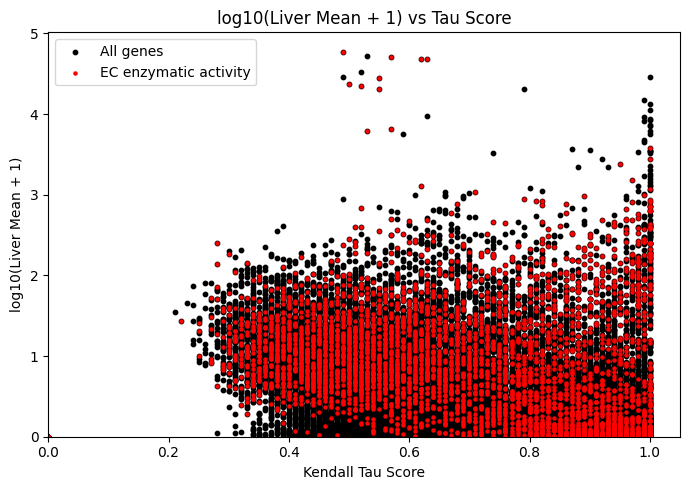

In [44]:
from wrangle_gtex_data import gtexData
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


gtex_data = gtexData.load_data(gtex_fn)

df_plot = gtex_data.gene_metadata

colsel = ['overall_mean', 'Liver_mean', 'tau_score','EC_enzymatic_activity', 'N_lines_dependent','crisprCommonEssential']
df_plot = df_plot[colsel].copy()

df_plot['tau_score'] = pd.to_numeric(df_plot['tau_score'], errors='coerce')
df_plot['Liver_mean'] = pd.to_numeric(df_plot['Liver_mean'], errors='coerce')
df_plot_clean = df_plot.dropna(subset=['tau_score', 'Liver_mean', 'EC_enzymatic_activity']).copy()

df_plot_clean['log10_liver_mean'] = np.log10(df_plot_clean['Liver_mean'] + 1)
df_plot_clean = df_plot_clean.drop(columns=['Liver_mean'])

## Plotting ##
plt.figure(figsize=(7, 5))

# Plot all points as small black dots using the new column
plt.scatter(
    df_plot_clean['tau_score'],
    df_plot_clean['log10_liver_mean'],
    color='black',
    s=10,
    label='All genes'
)

# Highlight points with EC_enzymatic_activity in red
mask_ec = df_plot_clean['EC_enzymatic_activity'].notnull() & (df_plot_clean['EC_enzymatic_activity'] != '')
plt.scatter(
    df_plot_clean.loc[mask_ec, 'tau_score'],
    df_plot_clean.loc[mask_ec, 'log10_liver_mean'],
    color='red',
    s=5,
    label='EC enzymatic activity'
)

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Kendall Tau Score')
plt.ylabel('log10(Liver Mean + 1)')
plt.title('log10(Liver Mean + 1) vs Tau Score')
plt.legend()
plt.tight_layout()
plt.savefig("../../../../input_figures/tau.score.vs.liver.lg10.tpm.png", bbox_inches='tight')
plt.show()

## We create a new data frame to collect the results and rank the results by 

df_target_selection = df_plot_clean
df_target_selection['rank_score'] = df_target_selection['log10_liver_mean'] * df_target_selection['tau_score']
df_target_selection = df_target_selection.sort_values('rank_score', ascending=False)
df_target_selection['rank'] = range(1, len(df_target_selection) + 1)
df_target_selection_ec = df_target_selection[
    df_target_selection['EC_enzymatic_activity'].notnull() & 
    (df_target_selection['EC_enzymatic_activity'] != '')
].copy()


## Tumor-normal differential gene expression (DGE)

To identify liver tumor-specific genes I've choosen [this summary single-cell dataset by Kang et al.](https://www.nature.com/articles/s41467-024-48310-4). In practice a comprehensive resource like the [genexcell dataportal from the Chan-Zuckerberg Biohub](https://cellxgene.cziscience.com/datasets) offers better programatic access to specific data selections. However, in this case the Kang et al dataset offers practical advantages: It features multiple patients for multiple cancer types with tumor and normal samples from the same individual and tissue. It also means that we can examine if tumor-specific gene expression is specific for a particular tissue or a general tumor-feature seen in many tissues.  

We will start by analysing the single-cell datasets as pseudobulk samples. This makes our initial assessment easier, and we can later dive into the single-cell data to determine which celltype was responsible for a tumor-specific increase in gene expression. For now we will focus on genes with increased expression, in order to identify genes the tumor might have gotten dependent on. This means if those activities are inhibited, the tumor growth and/or survival might be impacted. 

The differential gene expression analysis was performed in R, in a separate analysis. In part this is done so I can use an alrady existing analysis module, in part this is done because there is not yet a good implementation of the DESeq2 R-package for differential gene expression in python. 

The full pseudobulk RNAseq analysis can be reviewed (without password protection) at [this bulkRNAseq URL](https://biologic.crick.ac.uk/bulkliverdemo). The corresponding single-sell analysis will become available shortly at [this single-cell URL](https://biologic.crick.ac.uk/scliverdemo). For this analysis, we are going to load the liver tumor vs. normal pseudobulk differential gene expression results. 

In [35]:
## Load DGE results
import os

FnDGE = "../../../../data/pseudobulk.tumor.normal.dge.results.csv"

if os.path.isfile(FnDGE):
     df_DGE = pd.read_csv(FnDGE)

selcols =  ['hgnc_symbol'] + [col for col in df_DGE.columns if '_Liver_' in col]
df_DGE_liver = df_DGE[selcols].copy()

numeric_cols = df_DGE_liver.select_dtypes(include='number').columns

# Keep rows where at least one numeric column is not zero
df_DGE_liver = df_DGE_liver[(df_DGE_liver[numeric_cols] != 0).any(axis=1)].copy()
df_DGE_liver = df_DGE_liver.set_index('hgnc_symbol', drop=False)

df_add = df_DGE_liver[['logFC_Liver_T_vs_Liver_N' , 'padj_Liver_T_vs_Liver_N']]
df_target_selection = df_target_selection.merge(df_add, left_index=True, right_index=True, how='outer')
df_target_selection = df_target_selection.fillna(0)
df_target_selection = df_target_selection.infer_objects(copy=False)


## Selection of a gene set with liver-tumor specific expression ##
## We'll select all genes that are more than two 
std_value = df_DGE_liver['logFC_Liver_T_vs_Liver_N'].std()

tumor_specific_geneset = df_DGE_liver[df_DGE_liver['logFC_Liver_T_vs_Liver_N'] > 2* std_value].index

## Add to df_target_selection
df_target_selection['liver_tumor_upregulated'] = [
    '+' if gene in tumor_specific_geneset else '' for gene in df_target_selection.index
]




## Functional Validation
Validation from wetlab or in-silico screens can be done using functional data, e.g. showing that the knock-out of a given gene is required for tumor survival or development. Here we will use the DepMap dataset to try and validate the hits. Alternatively, validation can be done with genome-wide association (GWAS) or mendelian randomization (MR) data.  

For the top three hits we are going to plot DepMap score barcharts.

We are going to identify the genes that show a dependency in liver tissue. This we will cross-reference against our df_target_selection table. 

In [39]:
from wrangle_depmap_data import depmapData
import pandas as pd
import numpy as np

depmap_data = depmapData.load_data(depmap_fn)

df_meta = depmap_data.df_metadata
## filter for liver
df_meta_liversel= df_meta[df_meta['OncotreeLineage'] == "Liver"]
liverIDs = df_meta_liversel.index

df_crispr = depmap_data.df_crispr
liverIDs_filtered = [idx for idx in liverIDs if idx in df_crispr.index]
df_crispr_liver = df_crispr.loc[liverIDs_filtered]
cut_off_liver = -0.5

## Now we determine which genes show dependency scores below the cut-off in liver. 
df_essential = depmap_data.AchillesCommonEssentialControls
essential_genes = df_essential['gene_id']
df_binary = df_crispr_liver
df_binary =df_binary.drop(columns=[col for col in essential_genes if col in df_binary.columns]).copy()


df_binary = (df_binary < cut_off_liver).astype(int).copy()
df_column_sums = df_binary.sum(axis=0)
df_column_sums = df_column_sums.sort_values(ascending=False).copy()
df_column_sums = df_column_sums.to_frame(name='N_lines_dependent_in_liver')

df_column_sums = df_column_sums.sort_values(by='N_lines_dependent_in_liver', ascending=False)



## Add to target selection
df_target_selection = df_target_selection.merge(df_column_sums, left_index=True, right_index=True, how='outer')
df_target_selection = df_target_selection.fillna(0)


## Determine minimal dep score for each gene
min_values = df_crispr_liver.min(axis=0)

# Create a new DataFrame
df_min = min_values.reset_index()
df_min.columns = ['gene_id', 'min_crispr_score']
df_min = df_min.sort_values(by = "min_crispr_score", ascending = True)
df_min = df_min.set_index('gene_id', drop=True)
df_target_selection = df_target_selection.merge(df_min, left_index=True, right_index=True, how='outer')
df_target_selection = df_target_selection.fillna(0)
df_target_selection = df_target_selection.sort_values(by="rank", ascending = True)
df_target_selection.head(10)
df_target_selection.to_csv("../../../../input_tables/liver.target.selection.csv")

df_target_selection_ec = df_target_selection[
    df_target_selection['EC_enzymatic_activity'].notnull() & 
    (df_target_selection['EC_enzymatic_activity'] != '')
].copy()
df_target_selection_ec.head(10)
df_target_selection.to_csv("../../../../input_tables/liver.target.selection.enzymes.only.csv")

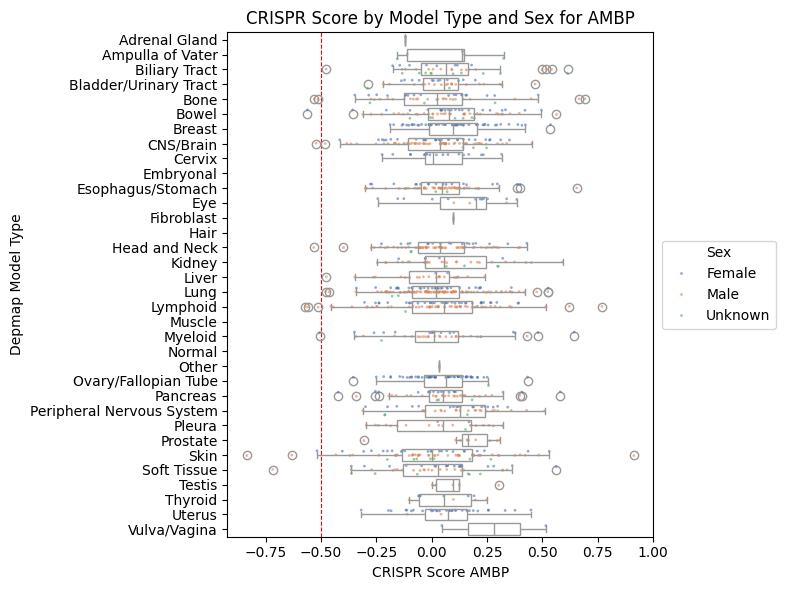

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set target gene and prepare data
target_gene = "AMBP"
df_temp = depmap_data.df_crispr[target_gene]
df_plot = depmap_data.df_metadata.join(df_temp, how='outer')
df_plot = df_plot.rename(columns={target_gene: 'crispr_dep_score'})
cut_off = -0.5

# Order y-axis by lineage
y_order = sorted(df_plot['OncotreeLineage'].dropna().unique())

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_plot,
    y='OncotreeLineage',
    x='crispr_dep_score',
    orient='h',
    order=y_order,
    color='white',
    showcaps=True,
    boxprops={'facecolor': 'none', "zorder": 10},
    whiskerprops={'zorder': 10},
    medianprops={'zorder': 11}
)

# Add vertical red line for cutoff
plt.axvline(x=cut_off, color='red', linestyle='--', linewidth=0.8, zorder=1)

# Overlay stripplot for individual data points
sns.stripplot(
    data=df_plot,
    y='OncotreeLineage',
    x='crispr_dep_score',
    hue='Sex',
    orient='h',
    dodge=True,
    size=2,
    alpha=0.6,
    palette='deep',
    order=y_order,
    jitter=True
)

plt.xlabel(f'CRISPR Score {target_gene}')
plt.ylabel('Depmap Model Type')
plt.title(f'CRISPR Score by Model Type and Sex for {target_gene}')

# Remove duplicate legend entries and place legend next to plot
handles, labels = plt.gca().get_legend_handles_labels()
n = len(set(df_plot['Sex']))
plt.legend(
    handles[:n], labels[:n], title='Sex',
    bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0
)

plt.tight_layout()
plt.savefig("../../../../input_figures/scores.per.celltype.partB.AMBP.png", bbox_inches='tight')
plt.show()